In [1]:
def log(*msg):
    print(*msg, file=sys.stdout)
    sys.stdout.flush()

def plot_snps(transcript, data, cohorts, width=750, height=300, palette='Category10'):

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
    ]\

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)] if len(cohorts) > 2 else palette[3]
    
    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[coh]
        df['cohort'] = coh
        fig1.triangle("x", coh, 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(-0.05, 1.1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))
    
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig

In [3]:
import malariagen_data
%run ../scripts/hapclust.py
import bokeh
import bokeh.plotting

In [203]:
%run ~/ag1000g/selective_sweeps/scripts/sweep_tools.py

ModuleNotFoundError: No module named 'pyfaidx'

In [4]:
fig_haplotypes_clustered

<function __main__.fig_haplotypes_clustered(h, distance_metric='hamming', linkage_method='single', truncate_distance=0, orientation='top', subplot_ratios=(4, 2), subplot_pad=0, despine_offset=5, count_sort=True, dend_linecolor='k', cut_height=2, highlight_clusters=True, highlight_colors=None, highlight_dend=True, highlight_freq=True, highlight_alpha=0.3, label_clusters=True, dpi=None, fig=None)>

In [204]:
%run tools.py

### VGSC typing

We want a function that will take a given gene and cohort query. Using malariaGen Data 


- Load genotypes 
- Load snpEff data for that gene 
- Cluster haplotypes/ genotypes and locate idx of swept inds. 
- Given gn, alt array, and pos, provide freqs for each base in dict {a:0.1, c:0.5, g:0.0, t:0.4}
- Get frequencies of SNPs in each swept group. 
- Store the non-synoymous snps in each sweep


And will cluster haps/gns, find swept haps, get allele freqs in each sweep of non-synonymous SNPs.



In [31]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

# Read metadata 
metadata = pd.read_csv("../../resources/metadata/samples.meta.spp.csv", sep=",")
metadata['location'] = metadata['location'].str.split(".").str.get(0)

chroms = ['2L', '2R', '3R', '3L', 'X']
snps = {}
pos = {}

for chrom in chroms:
    # Load Arrays
    snps[chrom], pos[chrom] = loadZarrArrays(genotypePath=f"../../resources/snp_genotypes/all/1244-VO-GH-YAWSON-VMF00149/{chrom}/calldata/GT", 
                                             positionsPath=f"../../resources/snp_genotypes/all/sites/{chrom}/variants/POS/",
                                             siteFilterPath=None, 
                                             haplotypes=False)
    
    

- subset to biallelic sites
- subset to region
- to_n_alt() then hap Array
- cluster
- get hap_indices above N(5) , make dict of sweeps and indices
- ag3.snp_allele_freqs() + ag3

In [342]:
def TranscriptSweptAlleleFreqs(geno, pos, transcript, haps=True, cut_height = 120, t=2, min_cohort_size=5, **kwargs):
    
    log("Finding start, stop...")
    start, stop = allel.gff3_to_dataframe("/home/sanj/ag1000g/data/reference/gff/An.gambiae-PEST-BASEFEATURES_agamP4.12.gff3", attributes=["ID"]).query("type == 'mRNA' & ID == @transcript")[['start', 'end']].to_numpy()[0]
    
    if haps == False:
        log("subsetting to biallelic markers")
        ac = geno.count_alleles()
        bial_ = ac.is_biallelic()
        bial_ = bial_.compute()

        transcript_bool = pos[bial_].locate_ranges([start], [stop])     
        pos = pos[bial_][transcript_bool]
        geno = geno.compress(bial_, axis=0).compress(transcript_bool, axis=0)
        haplos = allel.HaplotypeArray(geno.to_n_alt().compute())
    else:
        transcript_bool = pos.locate_ranges([start], [stop])     
        pos = pos[transcript_bool]
        haplos = geno.compress(transcript_bool, axis=0)
               
        
    log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150)
    plt.show()
    
    log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    if haps == True:
        df_snps_filtered = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, haps=haps, min_cohort_size=min_cohort_size, **kwargs)
    else:
        df_snps_filtered = clustersToFrequencies(transcript, cluster_spans, geno=geno, pos=pos, haps=haps, min_cohort_size=min_cohort_size, **kwargs)

    return(df_snps_filtered)
    
    
def clustersToFrequencies(transcript, cluster_spans, geno, pos, haps=False, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5):
    
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    print(cohorts)
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            print(coh, n_samples, min_cohort_size)
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            if haps== True:
                ac_coh = gt_coh.count_alleles(max_allele=3)
            else:
                ac_coh = allel.GenotypeArray(gt_coh).count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)
    
    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    ) 
    # Subset to our biallelic positions
    df_effects = df_effects.query("position in @pos")
    
    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)

    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )

    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    plot_snps(transcript, data=df_snps_filtered, cohorts=cohorts)
    return(df_snps_filtered)

Finding start, stop...
subsetting to biallelic markers
Clustering genotypes


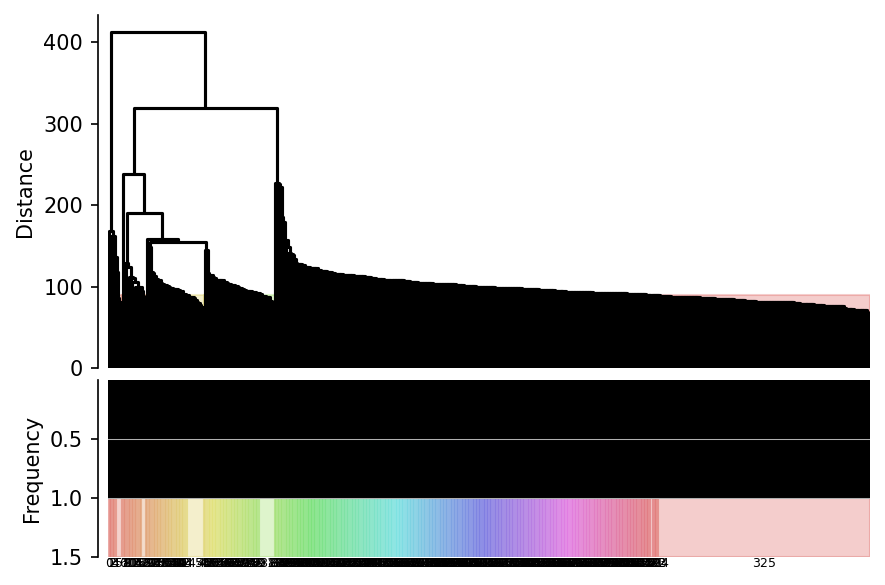

Finding allele frequencies from cluster indices
There are 7 clusters with [1, 4, 3, 11, 10, 2, 135]


In [244]:
vgscdf = TranscriptSweptAlleleFreqs(snps['2L'], pos['2L'], "AGAP004707-RD", haps=False, cut_height=90, t=2, min_cohort_size=0)

Finding start, stop...
subsetting to biallelic markers
Clustering genotypes


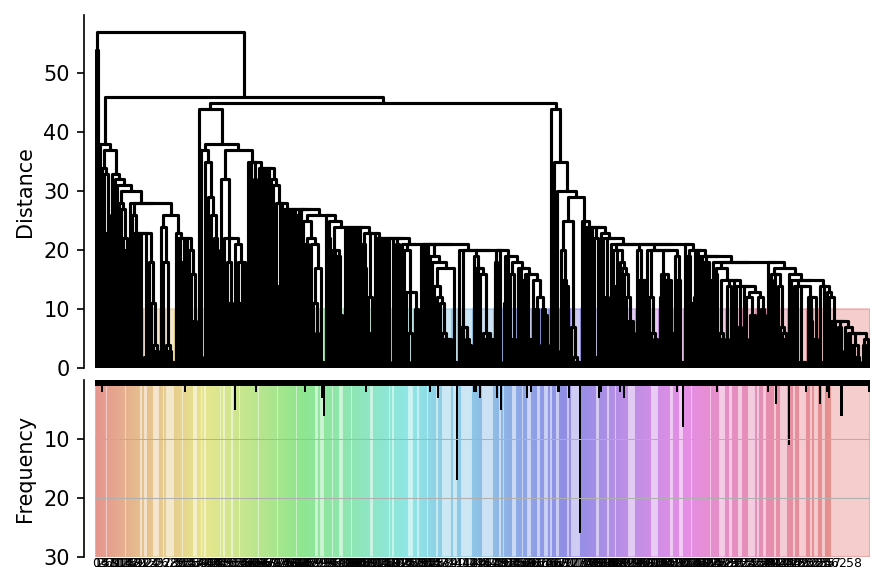

Finding allele frequencies from cluster indices
There are 6 clusters with [10, 19, 6, 30, 11, 25]


In [35]:
coe227df = TranscriptSweptAlleleFreqs(snps['2L'], pos['2L'], "AGAP006227-RA", haps=False, cut_height=10, t=0, min_cohort_size=0)

In [308]:
def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps, pos = loadZarrArrays(genotypePath=f"/home/sanj/ag1000g/data/phase3/snp_haplotypes/{sample_set}/gamb_colu/zarr/{contig}/calldata/GT/", 
                                         positionsPath=f"/home/sanj/ag1000g/data/phase3/snp_haplotypes/sites/gamb_colu/zarr/{contig}/variants/POS/",
                                         siteFilterPath=None)
    meta = ag3.sample_metadata(sample_set)
    if metaquery != None:
        meta = meta.query(metaquery) 
        snps = snps.take(meta.index.to_list(), axis=1)
        
    haps = snps.to_haplotypes()
    
    df_af = TranscriptSweptAlleleFreqs(haps, pos, transcript, haps=True, cut_height=cut, t=t, min_cohort_size=min_cohort_size)
    return(df_af)

Finding start, stop...
Clustering genotypes


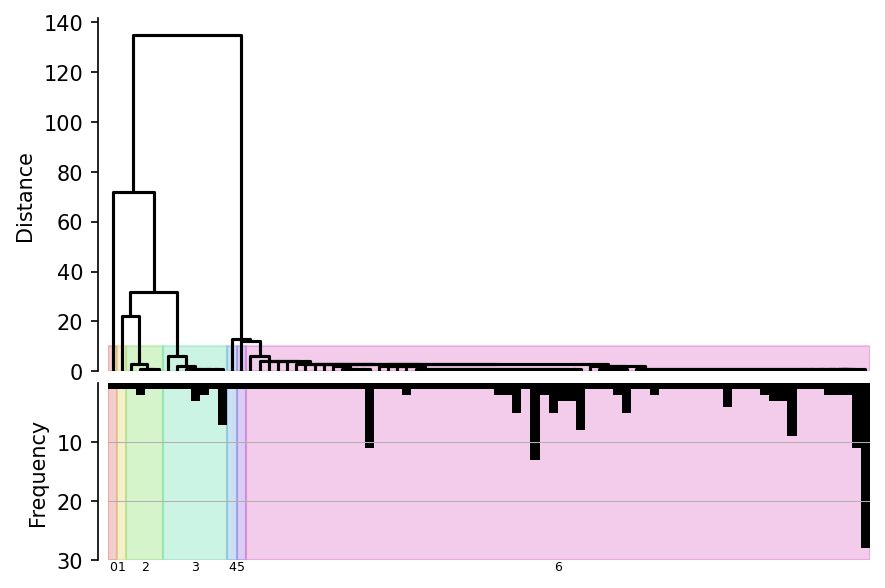

Finding allele frequencies from cluster indices
{'Sweep n=16': array([  1,   9,  11,  21,  35,  68,  69,  99, 115, 127, 137, 138, 149,
       151, 159, 162]), 'Sweep n=175': array([  0,   2,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  28,  29,  30,
        31,  32,  33,  34,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  70,  71,  72,  73,
        75,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130,
       131, 135, 136, 139, 140, 141, 142, 143, 144, 145, 146, 147, 150,
       152, 153, 154, 155, 156, 157, 158, 160, 161, 163, 164, 165, 166,
       167, 168, 170, 171, 172, 17

KeyError: 'wt n=4'

In [343]:
sample_set = "AG1000G-GH"
transcript = "AGAP004707-RD"
contig = '2L'

df = phase3cluster(sample_set, transcript, contig, cut=10, t=0, min_cohort_size=5)

Finding start, stop...
Clustering genotypes


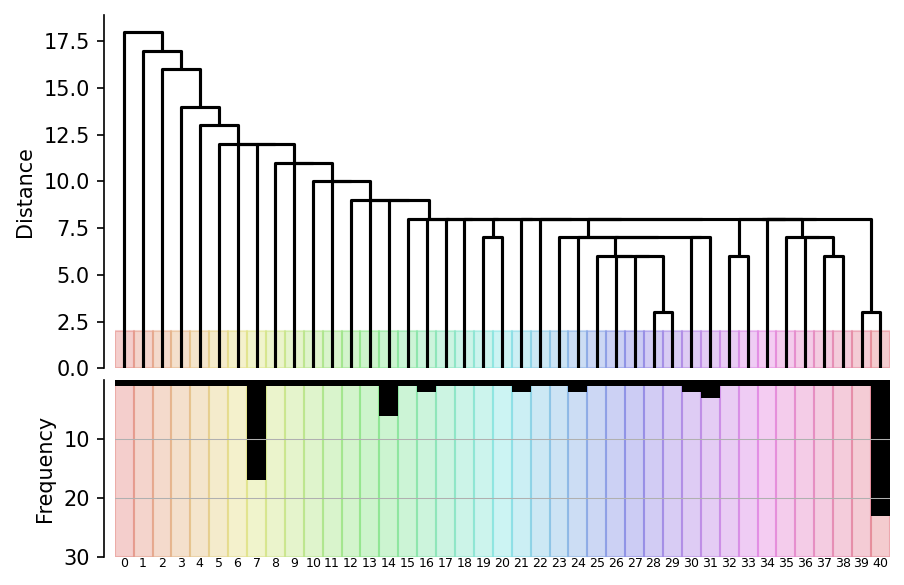

Finding allele frequencies from cluster indices
There are 6 clusters with [1, 17, 6, 2, 3, 23]


In [226]:
sample_set = "AG1000G-GN-A"
transcript = "AGAP006227-RA"
contig = '2L'

df = phase3cluster(sample_set, transcript, contig)

Finding start, stop...
Clustering genotypes


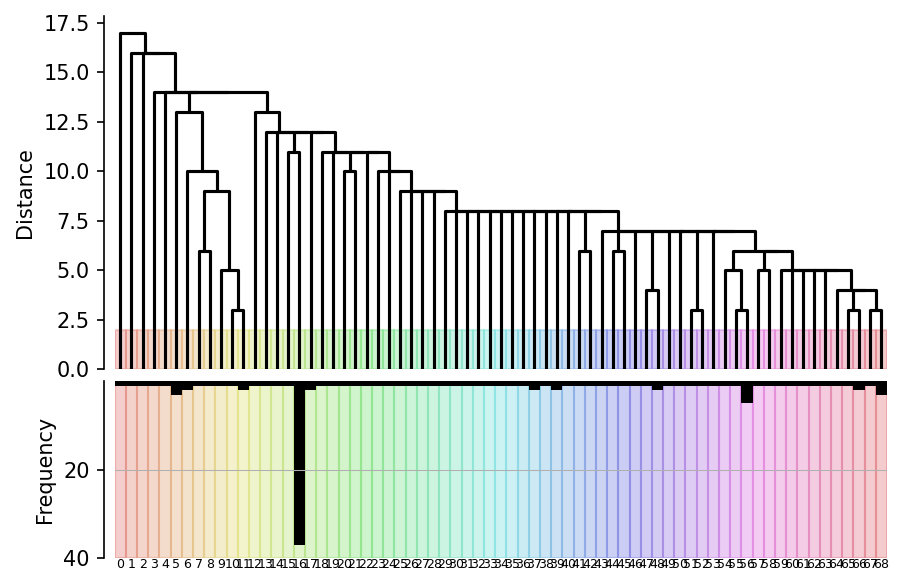

Finding allele frequencies from cluster indices
There are 5 clusters with [1, 3, 2, 37, 5]


In [222]:
sample_set = "AG1000G-ML-A"
transcript = "AGAP006227-RA"
contig = '2L'

df = phase3cluster(sample_set, transcript, contig)

Finding start, stop...
Clustering genotypes


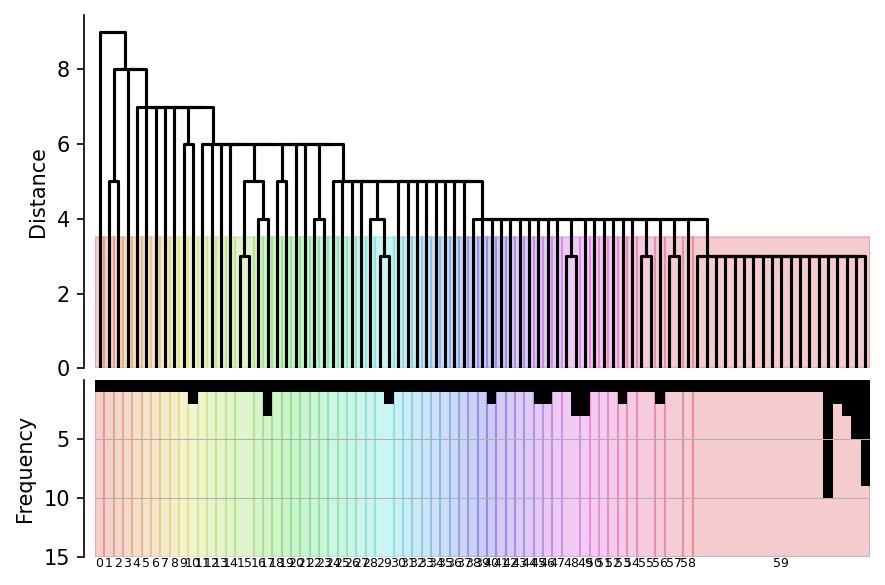

Finding allele frequencies from cluster indices
There are 2 clusters with [43, 77]


In [335]:
sample_set = "AG1000G-ML-A"
transcript = "AGAP008212-RA"
contig = '3R'

df = phase3cluster(sample_set, transcript, contig, cut=3.5, min_cohort_size=5)

Finding start, stop...
Clustering genotypes


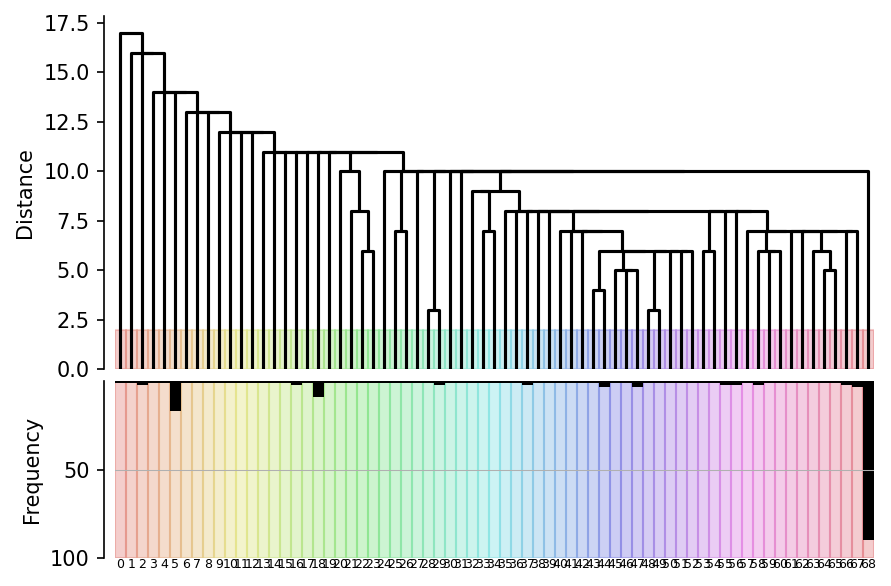

Finding allele frequencies from cluster indices
There are 4 clusters with [17, 9, 90, 80]


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/dask/array/routines.py:1951: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return a[(slice(None),) * axis + (indices,)]


In [313]:
sample_set = "AG1000G-BF-A"
transcript = "AGAP006227-RA"
contig = '2L'

df = phase3cluster(sample_set, transcript, contig, cut=2, metaquery="species_gambiae_coluzzii == 'gambiae'", min_cohort_size=5)